# Data Scientist Nanodegree

## Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 


This notebook walks you through one of the most popular Udacity projects across machine learning and artificial intellegence nanodegree programs.  The goal is to classify images of dogs according to their breed.  

If you are looking for a more guided capstone project related to deep learning and convolutional neural networks, this might be just it.  Notice that even if you follow the notebook to creating your classifier, you must still create a blog post or deploy an application to fulfill the requirements of the capstone project.

---

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.


---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write your Algorithm
* [Step 7](#step7): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


In [31]:
# Here we want to explore in more details how the data in each breed 
# is distributed between train, test, and validation datasets. 

from pathlib import Path
import os

# initialising variables with empty list and/or doctionary
breeds_name = []
train_dic = {} 
test_dic = {} 
valid_dic = {} 

# count number of samples in each folder inside the train directory and
# save them into a dictionary withe the breed name as the key
for i in range(len(train_files)):
    p = Path(train_files[i])
    name = p.parts[6].split('.')[1]
    breeds_name.append(name)
    _, _, files = next(os.walk(str(p.parent)))
    train_dic[name] = len(files)/len(train_files)*100 # we find the ration of number of samples to the total value of samples 

# count number of samples in each folder inside the test directory and
# save them into a dictionary withe the breed name as the key
for i in range(len(test_files)):
    p = Path(test_files[i])
    name = p.parts[6].split('.')[1]
    _, _, files = next(os.walk(str(p.parent)))
    test_dic[name] = len(files)/len(test_files)*100 # we find the ration of number of samples to the total value of samples

# count number of samples in each folder inside the validation directory and
# save them into a dictionary withe the breed name as the key
for i in range(len(valid_files)):
    p = Path(valid_files[i])
    name = p.parts[6].split('.')[1]
    _, _, files = next(os.walk(str(p.parent)))
    valid_dic[name] = len(files)/len(valid_files)*100 # we find the ration of number of samples to the total value of samples

Text(0,0.5,'Ratio of sample number to total dataset size in each group (%)')

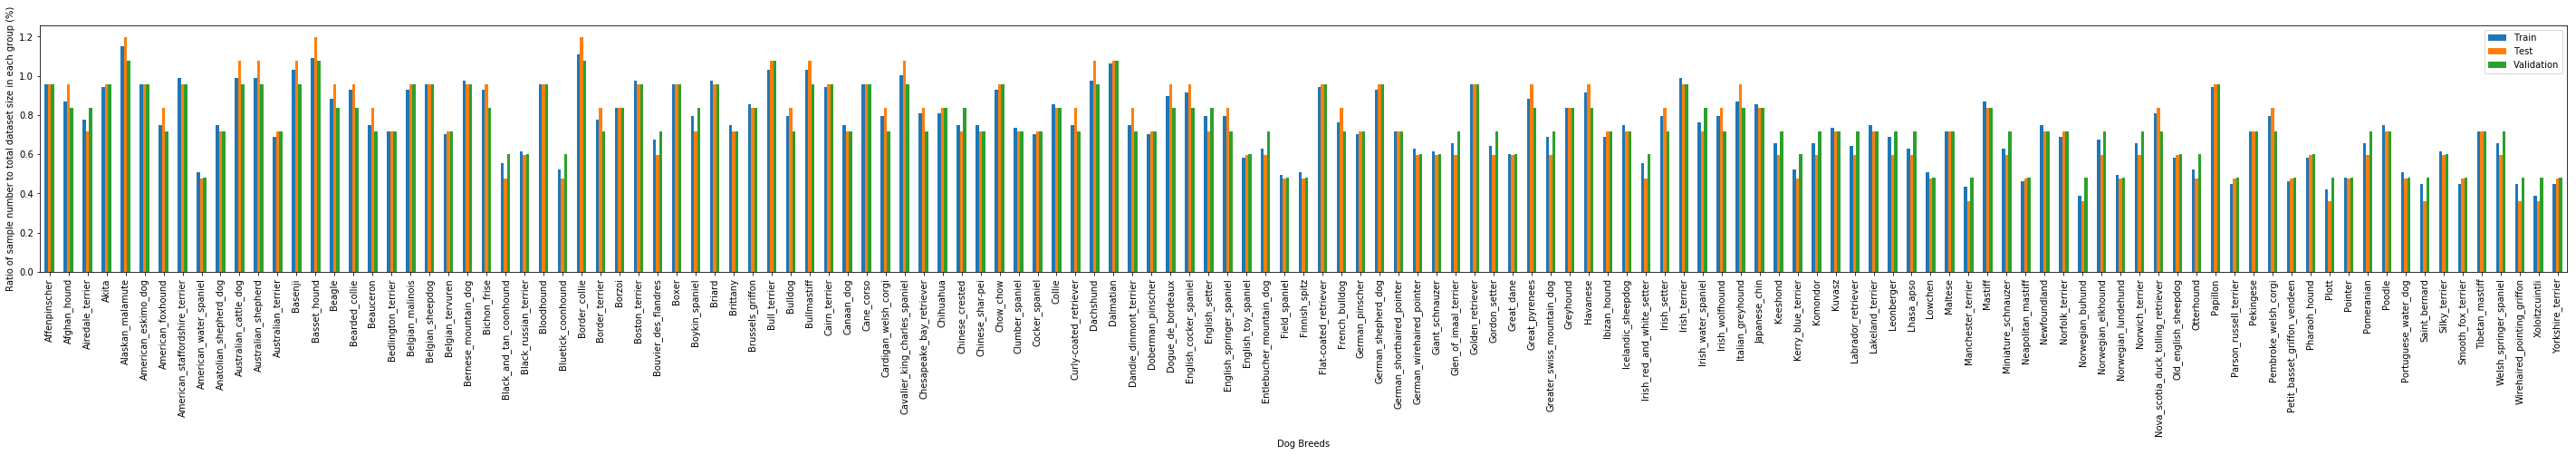

In [30]:
# Here we plot the percentage of sampes in each group for different dog breeds
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({'Train': pd.Series(train_dic), 'Test': pd.Series(test_dic), 
                   'Validation': pd.Series(valid_dic) })
plt.rcParams['figure.figsize'] = [50, 5]
ax = df.plot.bar()
plt.xlabel('Dog Breeds')
plt.ylabel('Ratio of sample number to total dataset size in each group (%)')


As you can see above, we have similar percentage of samples (share of samples) for each bread for each train, test, and validation dataset. Therefore, we train model, validate and test them on sets of same distributions and therefore are comparable. Therefore, we can measure accuracy as a metric to assess the model performance. Accuracy is measured as the fraction of correctly identified images by the total number of images in our dataset.     

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [21]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


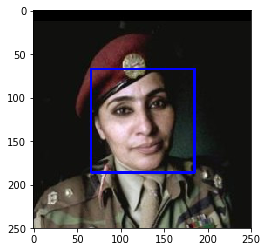

In [22]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [23]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ As the test below shows 100% of the first 100 images in `human_files` have a detected human face. However, we found that 11% of the first 100 images in `dog_files` have also been detected as having human faces in them. This might show that our human face detection algorithm does not work properly when indroduced by other images rather than human images (e.g. dog images). On the other hand there is a slight chance that some of the dog images include human faces as well which this may have caused our function to detect human in some of the dog images. 

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_human_found = 0
dog_human_found = 0
for i in range(len(human_files_short)):
    if face_detector(human_files_short[i]):
        human_human_found += 1
    if face_detector(dog_files_short[i]):
        dog_human_found += 1
        
Correctly_human_ditected = human_human_found/len(human_files_short) *100
Incorrectly_human_ditected = dog_human_found/len(dog_files_short) *100

print("we found {}% of the human images with a detected face and {}% of dog images with detected human face"\
      .format(Correctly_human_ditected, Incorrectly_human_ditected))

we found 100.0% of the human images with a detected face and 11.0% of dog images with detected human face


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__ We can generate probabilities instead of a binary output of whether the image has a human face or not. The algorithm can be trained on many images with clear and unclear images of faces (or even other animals faces) and give a percentage of how certainly a image of human face is detected (or using a multiclass classification to find human and other animals faces). We can also combine the human face detector function with a dog predictor function and find those images that includes both dog and human in them and for such images we notify the user that the image includes both human and dog faces in it. Then we can remove the human face or the dog face and do the our intended process on the image. 

We suggest the face detector from OpenCV as a potential way to detect human images in the algorithm.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [15]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model_1 = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [3]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [16]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model_1.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [17]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ As the results in the cell below shows our dog detector algorithm using the pretrained ResNet50 model works perfectly with detecting 0% dog faces in the first 100 human images and detecting 100% dog faces in the first 100 dog images. 

In [10]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def count_dogface_detected(input_files):
    count = 0
    for i in range(len(input_files)):
        if dog_detector(input_files[i]):
            count += 1
    return count
        
Incorrectly_dog_detected = count_dogface_detected(human_files_short)/len(human_files_short) *100
Correctly_dog_detected = count_dogface_detected(dog_files_short)/len(dog_files_short) *100

print("We found {}% of the human images with a detected dog face and {}% of dog images with detected dog face"\
      .format(Incorrectly_dog_detected, Correctly_dog_detected))

We found 0.0% of the human images with a detected dog face and 100.0% of dog images with detected dog face


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We must create a CNN _from scratch_ (so, can't use transfer learning _yet_!), and must attain a test accuracy of at least 1%.  In Step 5 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [11]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# Here I chose a slice of Training dataset to work with as the Kernel 
# could not handle the big dataset when turned into tensor
train_files_s = train_files[:3000]
train_targets_s = train_targets[:3000]
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files_s).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:09<00:00, 89.09it/s] 


### (IMPLEMENTATION) Model Architecture

Her we create a CNN to classify dog breed.  At the end of the code cell block, we summarize the layers of the model by executing the line:
    
        model.summary()

Here is the outline of the model that we use, that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ The CNN model includes three convolutional layers, which each is followed by a max pooling layer. The input shape (as explained before in data pre-processing) is (224*224*3) indicating a square image of 224 by 224 pixels and 3 channels for the three colors (GRB). At each convolutional layer we increase the depth of our 3D array step by step by using 16, 32, and 64 filter respectively. The Max-pooling layer on the other hand decreses the special complexity at each layer and only keep the important features in the image. Increasing the number of covolutional layer and MAx-pooling increases the performance of our model as it becomes more capable of extracting important features in the images, which are important for how good the model can predict the right output for an input image. However, increasing convolutional layers is computationaly expensive therefore we kept the number of layers to 3 layers at this stage. The output of the last MAx-pooling layer is then flattened into a vector and fed to a fully connected layer (dense layer) to use the features to predict what the image is. We have used "softmax" activation as we want the model to tell us that the input image belongs to what dogs' breed (133 different classes/breeds). 

In [12]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Define our model architecture.
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D())
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [5]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

We train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.


In [7]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that we would like to use to train the model.

epochs = 20

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets_s, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 3000 samples, validate on 835 samples
Epoch 1/20
3000/3000 [==============================] - 12s 4ms/step - loss: 4.8895 - acc: 0.0073 - val_loss: 4.8817 - val_acc: 0.0108
Epoch 2/20
3000/3000 [==============================] - 11s 4ms/step - loss: 4.8741 - acc: 0.0143 - val_loss: 4.8738 - val_acc: 0.0108
Epoch 3/20
3000/3000 [==============================] - 11s 4ms/step - loss: 4.8650 - acc: 0.0130 - val_loss: 4.8705 - val_acc: 0.0108
Epoch 4/20
3000/3000 [==============================] - 11s 4ms/step - loss: 4.8555 - acc: 0.0130 - val_loss: 4.8710 - val_acc: 0.0108
Epoch 5/20
3000/3000 [==============================] - 11s 4ms/step - loss: 4.8392 - acc: 0.0160 - val_loss: 4.8508 - val_acc: 0.0108
Epoch 6/20
3000/3000 [==============================] - 11s 4ms/step - loss: 4.8177 - acc: 0.0180 - val_loss: 4.8456 - val_acc: 0.0108
Epoch 7/20
3000/3000 [==============================] - 11s 4ms/step - loss: 4.8004 - acc: 0.0180 - val_loss: 4.8356 - val_acc: 0.0204
Epoch 8/

### Load the Model with the Best Validation Loss

In [8]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out the model on the test dataset of dog images.  Ensure that the test accuracy is greater than 1%.

In [9]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.8708%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show here how to train a CNN using transfer learning.  In the following step, we will have a chance to use transfer learning to train our CNN.

### Obtain Bottleneck Features

In [10]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

In [11]:
train_VGG16.shape

(6680, 7, 7, 512)

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [12]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [13]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [14]:
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 567us/step - loss: 12.3700 - acc: 0.1277 - val_loss: 10.9002 - val_acc: 0.2012
Epoch 2/20
6680/6680 [==============================] - 4s 586us/step - loss: 10.3765 - acc: 0.2741 - val_loss: 10.2487 - val_acc: 0.2838
Epoch 3/20
6680/6680 [==============================] - 4s 543us/step - loss: 9.9038 - acc: 0.3280 - val_loss: 10.0476 - val_acc: 0.3138
Epoch 4/20
6680/6680 [==============================] - 4s 553us/step - loss: 9.7002 - acc: 0.3611 - val_loss: 9.8800 - val_acc: 0.3317
Epoch 5/20
6680/6680 [==============================] - 4s 551us/step - loss: 9.5253 - acc: 0.3795 - val_loss: 9.7838 - val_acc: 0.3293
Epoch 6/20
6680/6680 [==============================] - 4s 548us/step - loss: 9.3585 - acc: 0.3919 - val_loss: 9.6543 - val_acc: 0.3533
Epoch 7/20
6680/6680 [==============================] - 4s 559us/step - loss: 9.2546 - acc: 0.4087 - val_loss: 9.6331 - val_acc: 0.3

### Load the Model with the Best Validation Loss

In [15]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [16]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 41.2679%


### Predict Dog Breed with the Model

In [17]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

Here we use transfer learning (using other available pre-trained models) to create a CNN that can identify dog breed from images.  We look for a CNN that attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [35]:
# Obtaining bottleneck features from another pre-trained CNN (VGG19).

bottleneck_features = np.load('bottleneck_features/DogVGG19Data.npz')
train_VGG19 = bottleneck_features['train']
valid_VGG19 = bottleneck_features['valid']
test_VGG19 = bottleneck_features['test']

In [9]:
# Obtaining bottleneck features from another pre-trained CNN (Resnet50).

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_ResNet50 = bottleneck_features['train']
valid_ResNet50 = bottleneck_features['valid']
test_ResNet50 = bottleneck_features['test']

In [75]:
# Obtaining bottleneck features from another pre-trained CNN (InceptionV3).

bottleneck_features = np.load('bottleneck_features/DogInceptionV3Data.npz')
train_InceptionV3 = bottleneck_features['train']
valid_InceptionV3 = bottleneck_features['valid']
test_InceptionV3 = bottleneck_features['test']

In [4]:
# Obtaining bottleneck features from another pre-trained CNN (Xception).

bottleneck_features = np.load('bottleneck_features/DogXceptionData.npz')
train_Xception = bottleneck_features['train']
valid_Xception = bottleneck_features['valid']
test_Xception = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of the model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ Here I used the 4 different pretrained CNN models. Becuase they are all trained on the dog images therefore our dataset is similar to the pretrained dataset. Therefore, I removed the last fully connected layers and replaced it with my own layers: 1 Global Average Pooling to reduce the input size in to a flatten vector, and 1 fully connected/Dense layer with 133 classes, matching the number of different dog breadings. The Summary after each model architecture shows the total number of parameters considered in each model.

In VGG19 model I also tried removing the Global Average Pooling layer and replace it with a convolutional layer, a maxPooling and a Flatten layer but the accuracy of the model on the test dataset decreased even lower than when I have only the GlobalAveragePooling layer. So I kept the architecture for VGG19 as below. However as you can see further down the notebook the accuracy of the model on the test data set is still less than 60%. So I moved to the next pretrained models as you can see below:

In [69]:
# Define model architecture (VGG19).
#from keras.layers import MaxPooling2D, Flatten

VGG19_model = Sequential()
VGG19_model.add(GlobalAveragePooling2D(input_shape=train_VGG19.shape[1:]))
#VGG19_model.add(Conv2D(filters=1024, kernel_size=2, padding='same', activation='relu', input_shape=train_VGG19.shape[1:]))
#VGG19_model.add(MaxPooling2D(pool_size=2))
#VGG19_model.add(Flatten())
VGG19_model.add(Dense(133, activation='softmax'))

VGG19_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_11  (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


In [46]:
train_VGG19.shape

(6680, 7, 7, 512)

In [13]:
# Define model architecture (ResNet50).
ResNet50_model = Sequential()
ResNet50_model.add(GlobalAveragePooling2D(input_shape=train_ResNet50.shape[1:]))
ResNet50_model.add(Dense(133, activation='softmax'))

ResNet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Define model architecture (InceptionV3).
InceptionV3_model = Sequential()
InceptionV3_model.add(GlobalAveragePooling2D(input_shape=train_InceptionV3.shape[1:]))
InceptionV3_model.add(Dense(133, activation='softmax'))

InceptionV3_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_12  (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Define model architecture (Xception).
Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=train_Xception.shape[1:]))
Xception_model.add(Dense(133, activation='softmax'))

Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [70]:
# Compile the model (VGG19).
VGG19_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [15]:
# Compile the model (ResNet50).
ResNet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [77]:
# Compile the model (InceptionV3).
InceptionV3_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [9]:
# Compile the model (Xception).
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train the model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  


In [71]:
# Train the model (VGG19).
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG19.hdf5', 
                               verbose=1, save_best_only=True)

VGG19_model.fit(train_VGG19, train_targets, 
          validation_data=(valid_VGG19, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 595us/step - loss: 11.8672 - acc: 0.1277 - val_loss: 10.2918 - val_acc: 0.2299
Epoch 2/20
6680/6680 [==============================] - 4s 561us/step - loss: 9.4502 - acc: 0.3057 - val_loss: 9.4784 - val_acc: 0.2874
Epoch 3/20
6680/6680 [==============================] - 4s 558us/step - loss: 8.8188 - acc: 0.3783 - val_loss: 9.1875 - val_acc: 0.3293
Epoch 4/20
6680/6680 [==============================] - 4s 566us/step - loss: 8.5805 - acc: 0.4106 - val_loss: 8.9964 - val_acc: 0.3461
Epoch 5/20
6680/6680 [==============================] - 4s 552us/step - loss: 8.3773 - acc: 0.4308 - val_loss: 8.8725 - val_acc: 0.3581
Epoch 6/20
6680/6680 [==============================] - 4s 557us/step - loss: 8.2335 - acc: 0.4540 - val_loss: 8.7261 - val_acc: 0.3629
Epoch 7/20
6680/6680 [==============================] - 4s 556us/step - loss: 8.0714 - acc: 0.4672 - val_loss: 8.6069 - val_acc: 0.3772

In [32]:
# Train the model (ResNet50).
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

ResNet50_model.fit(train_ResNet50, train_targets, 
          validation_data=(valid_ResNet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 566us/step - loss: 0.0046 - acc: 0.9991 - val_loss: 0.9510 - val_acc: 0.8228
Epoch 2/20
6680/6680 [==============================] - 4s 572us/step - loss: 0.0060 - acc: 0.9985 - val_loss: 0.9295 - val_acc: 0.8275
Epoch 3/20
6680/6680 [==============================] - 4s 563us/step - loss: 0.0059 - acc: 0.9984 - val_loss: 0.9763 - val_acc: 0.8228
Epoch 4/20
6680/6680 [==============================] - 4s 552us/step - loss: 0.0048 - acc: 0.9991 - val_loss: 0.9036 - val_acc: 0.8395
Epoch 5/20
6680/6680 [==============================] - 4s 543us/step - loss: 0.0039 - acc: 0.9990 - val_loss: 0.9345 - val_acc: 0.8383
Epoch 6/20
6680/6680 [==============================] - 4s 555us/step - loss: 0.0053 - acc: 0.9987 - val_loss: 1.0322 - val_acc: 0.8263
Epoch 7/20
6680/6680 [==============================] - 4s 550us/step - loss: 0.0063 - acc: 0.9988 - val_loss: 1.0006 - val_acc: 0.8383
E

In [78]:
# Train the model (InceptionV3).
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.InceptionV3.hdf5', 
                               verbose=1, save_best_only=True)

InceptionV3_model.fit(train_InceptionV3, train_targets, 
          validation_data=(valid_InceptionV3, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 4s 607us/step - loss: 1.1574 - acc: 0.7129 - val_loss: 0.6623 - val_acc: 0.8287
Epoch 2/20
6680/6680 [==============================] - 4s 562us/step - loss: 0.4763 - acc: 0.8560 - val_loss: 0.6201 - val_acc: 0.8443
Epoch 3/20
6680/6680 [==============================] - 4s 562us/step - loss: 0.3693 - acc: 0.8864 - val_loss: 0.7032 - val_acc: 0.8419
Epoch 4/20
6680/6680 [==============================] - 4s 556us/step - loss: 0.2890 - acc: 0.9109 - val_loss: 0.6506 - val_acc: 0.8467
Epoch 5/20
6680/6680 [==============================] - 4s 552us/step - loss: 0.2421 - acc: 0.9211 - val_loss: 0.6810 - val_acc: 0.8407
Epoch 6/20
6680/6680 [==============================] - 4s 559us/step - loss: 0.2083 - acc: 0.9370 - val_loss: 0.7413 - val_acc: 0.8371
Epoch 7/20
6680/6680 [==============================] - 4s 561us/step - loss: 0.1727 - acc: 0.9467 - val_loss: 0.7345 - val_acc: 0.8455
E

In [18]:
# Train the model (Xception).
#from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)

Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 6s 937us/step - loss: 1.0614 - acc: 0.7374 - val_loss: 0.4957 - val_acc: 0.8467
Epoch 2/20
6680/6680 [==============================] - 6s 826us/step - loss: 0.4052 - acc: 0.8714 - val_loss: 0.5262 - val_acc: 0.8311
Epoch 3/20
6680/6680 [==============================] - 5s 747us/step - loss: 0.3244 - acc: 0.9000 - val_loss: 0.4860 - val_acc: 0.8431
Epoch 4/20
6680/6680 [==============================] - 6s 826us/step - loss: 0.2764 - acc: 0.9136 - val_loss: 0.4850 - val_acc: 0.8407
Epoch 5/20
6680/6680 [==============================] - 5s 814us/step - loss: 0.2484 - acc: 0.9243 - val_loss: 0.4880 - val_acc: 0.8587
Epoch 6/20
6680/6680 [==============================] - 5s 751us/step - loss: 0.2191 - acc: 0.9316 - val_loss: 0.4994 - val_acc: 0.8671
Epoch 7/20
6680/6680 [==============================] - 5s 821us/step - loss: 0.1942 - acc: 0.9416 - val_loss: 0.5584 - val_acc: 0.8539
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [72]:
# Load the model weights with the best validation loss (VGG19).
VGG19_model.load_weights('saved_models/weights.best.VGG19.hdf5')

In [19]:
# Load the model weights with the best validation loss (ResNEt50).
ResNet50_model.load_weights('saved_models/weights.best.ResNet50.hdf5')

In [80]:
# Load the model weights with the best validation loss (InceptionV3).
InceptionV3_model.load_weights('saved_models/weights.best.InceptionV3.hdf5')

In [10]:
# Load the model weights with the best validation loss (Xception).
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [73]:
# Calculate classification accuracy on the test dataset (for model VGG19).

# get index of predicted dog breed for each image in test set
VGG19_predictions = [np.argmax(VGG19_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG19]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG19_predictions)==np.argmax(test_targets, axis=1))/len(VGG19_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 42.9426%


In [34]:
# Calculate classification accuracy on the test dataset (for model ResNet50).

# get index of predicted dog breed for each image in test set
ResNet50_predictions = [np.argmax(ResNet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_ResNet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(ResNet50_predictions)==np.argmax(test_targets, axis=1))/len(ResNet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 82.1770%


In [81]:
# Calculate classification accuracy on the test dataset (for model InceptionV3).

# get index of predicted dog breed for each image in test set
InceptionV3_predictions = [np.argmax(InceptionV3_model.predict(np.expand_dims(feature, axis=0))) for feature in test_InceptionV3]

# report test accuracy
test_accuracy = 100*np.sum(np.array(InceptionV3_predictions)==np.argmax(test_targets, axis=1))/len(InceptionV3_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 78.3493%


In [21]:
# Calculate classification accuracy on the test dataset (for model Xception).

# get index of predicted dog breed for each image in test set
Xception_predictions = [np.argmax(Xception_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Xception]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Xception_predictions)==np.argmax(test_targets, axis=1))/len(Xception_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 85.4067%


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by your model.  

Similar to the analogous function in Step 5, your function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, you need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [11]:
# Write a function that takes a path to an image as input
# and returns the dog breed that is predicted by the model.
from extract_bottleneck_features import *

def VResNet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = ResNet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

def Xception_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [24]:
VResNet50_predict_breed('images/American_water_spaniel_00648.jpg').split('.')[-1]


94658560/94653016 [==============================] - 1s 0us/step


'Boykin_spaniel'

In [23]:
Xception_predict_breed('images/American_water_spaniel_00648.jpg').split('.')[-1]

83689472/83683744 [==============================] - 1s 0us/step


'American_water_spaniel'

It seems that Xception model predictor does a better job in pedicting dog breeds with test accuracy of about 85%. The example above also shows that ResNet50 predicted _Boykin-spaniel_ for an American-water-spaniel dog while Xception could correctly predict the correct breed. So I will be using the Xception predictor in the next step.

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

We use the `face_detector` and `dog_detector` functions developed above and use the CNN from Step 5 to predict dog breed.  

A sample image and output for our algorithm is provided below, but we design our own user experience!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) Write your Algorithm

In [12]:
def main_detector_func(file_path):
    '''
    This function uses two functions dog_detector and face_detector to 
    first find if the photo is a dog or a human face. If it find that 
    it is a dog photo it find what breed it is. If it is a human face 
    it tries to find the best fit of that face to a dog breed.
    If the image is neither and human nor a dog then it generates
    a message indicating that.
    
    Input:
        file_path: the path to the image that needs to be processed
    Output:
        Non
    '''
    from PIL import Image 
    import IPython.display as display
  
    # creating image object 
    img = Image.open(file_path) 

    # using convert method  
    img1 = img.convert("RGB") 
    #img1.show() 
    display.display(img1)

  
    
    if dog_detector(file_path):
        dog_breed = Xception_predict_breed(file_path).split('.')[-1] #VResNet50_predict_breed(file_path).split('.')[-1]
        print('This is a dog photo and the breed is {}'.format(dog_breed))
    elif face_detector(file_path):
        dog_breed = Xception_predict_breed(file_path).split('.')[-1] #VResNet50_predict_breed(file_path).split('.')[-1]
        print('This is a human photo but it looks like {} dog breed'.format(dog_breed))
    else:
        print('This is neither a dog nor a human')
        

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, we will take the new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test the algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output is better than I expected. It finds the dogs' breed pretty good even for a poppy image as you can see below. The algorithm also correctly distinguishes a random image which is neither human nor a dog. Associating a dog breed to a human face seems a bit tricky. Checking the predicted breed for the human faces for the 2 examples below seems similar to the faces but there are other breeds that can also be associated to them. For example maybe for the first human face image a _bull terrier_ would be a better match?! but the predicted dog breed for the second human face image is a very good match. 

Suggestions for improvement:
1) We can expand our data by using _Image Augmentation_ in order to make the model invarient to the factors such as scale, rotation, and translation
2) Increasing the number of epochs while using _EarlyStopping_ can help to get to a better accuracy while avoiding overfitting
3) Fine-tune our model by unfreeze a few of the top layers (in the pretrained base model) and jointly train them along with the newly added layers (We can add more layers such as Covolutional, Maxpooling, etc and train them). With this we can fine-tune higher-order features in the base model in order to make them more relevant to our specific task.

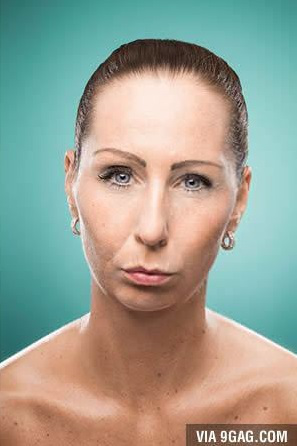

This is a human photo but it looks like Cane_corso dog breed


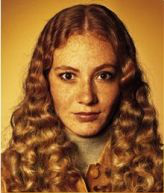

This is a human photo but it looks like Cavalier_king_charles_spaniel dog breed


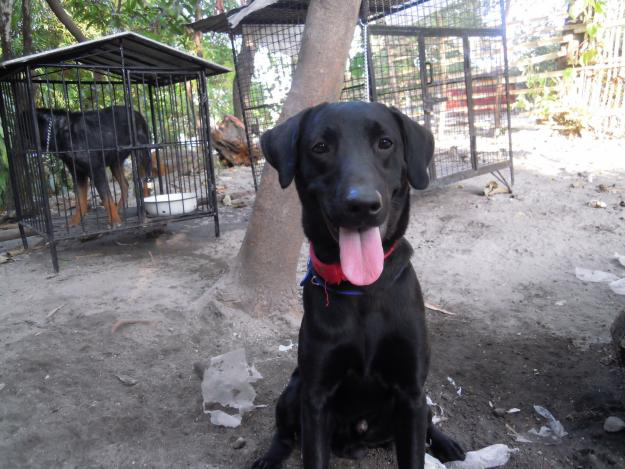

This is a dog photo and the breed is Labrador_retriever


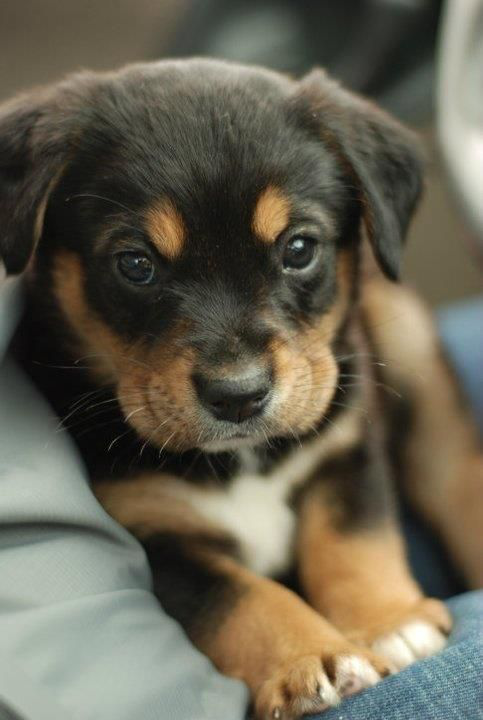

This is a dog photo and the breed is German_pinscher


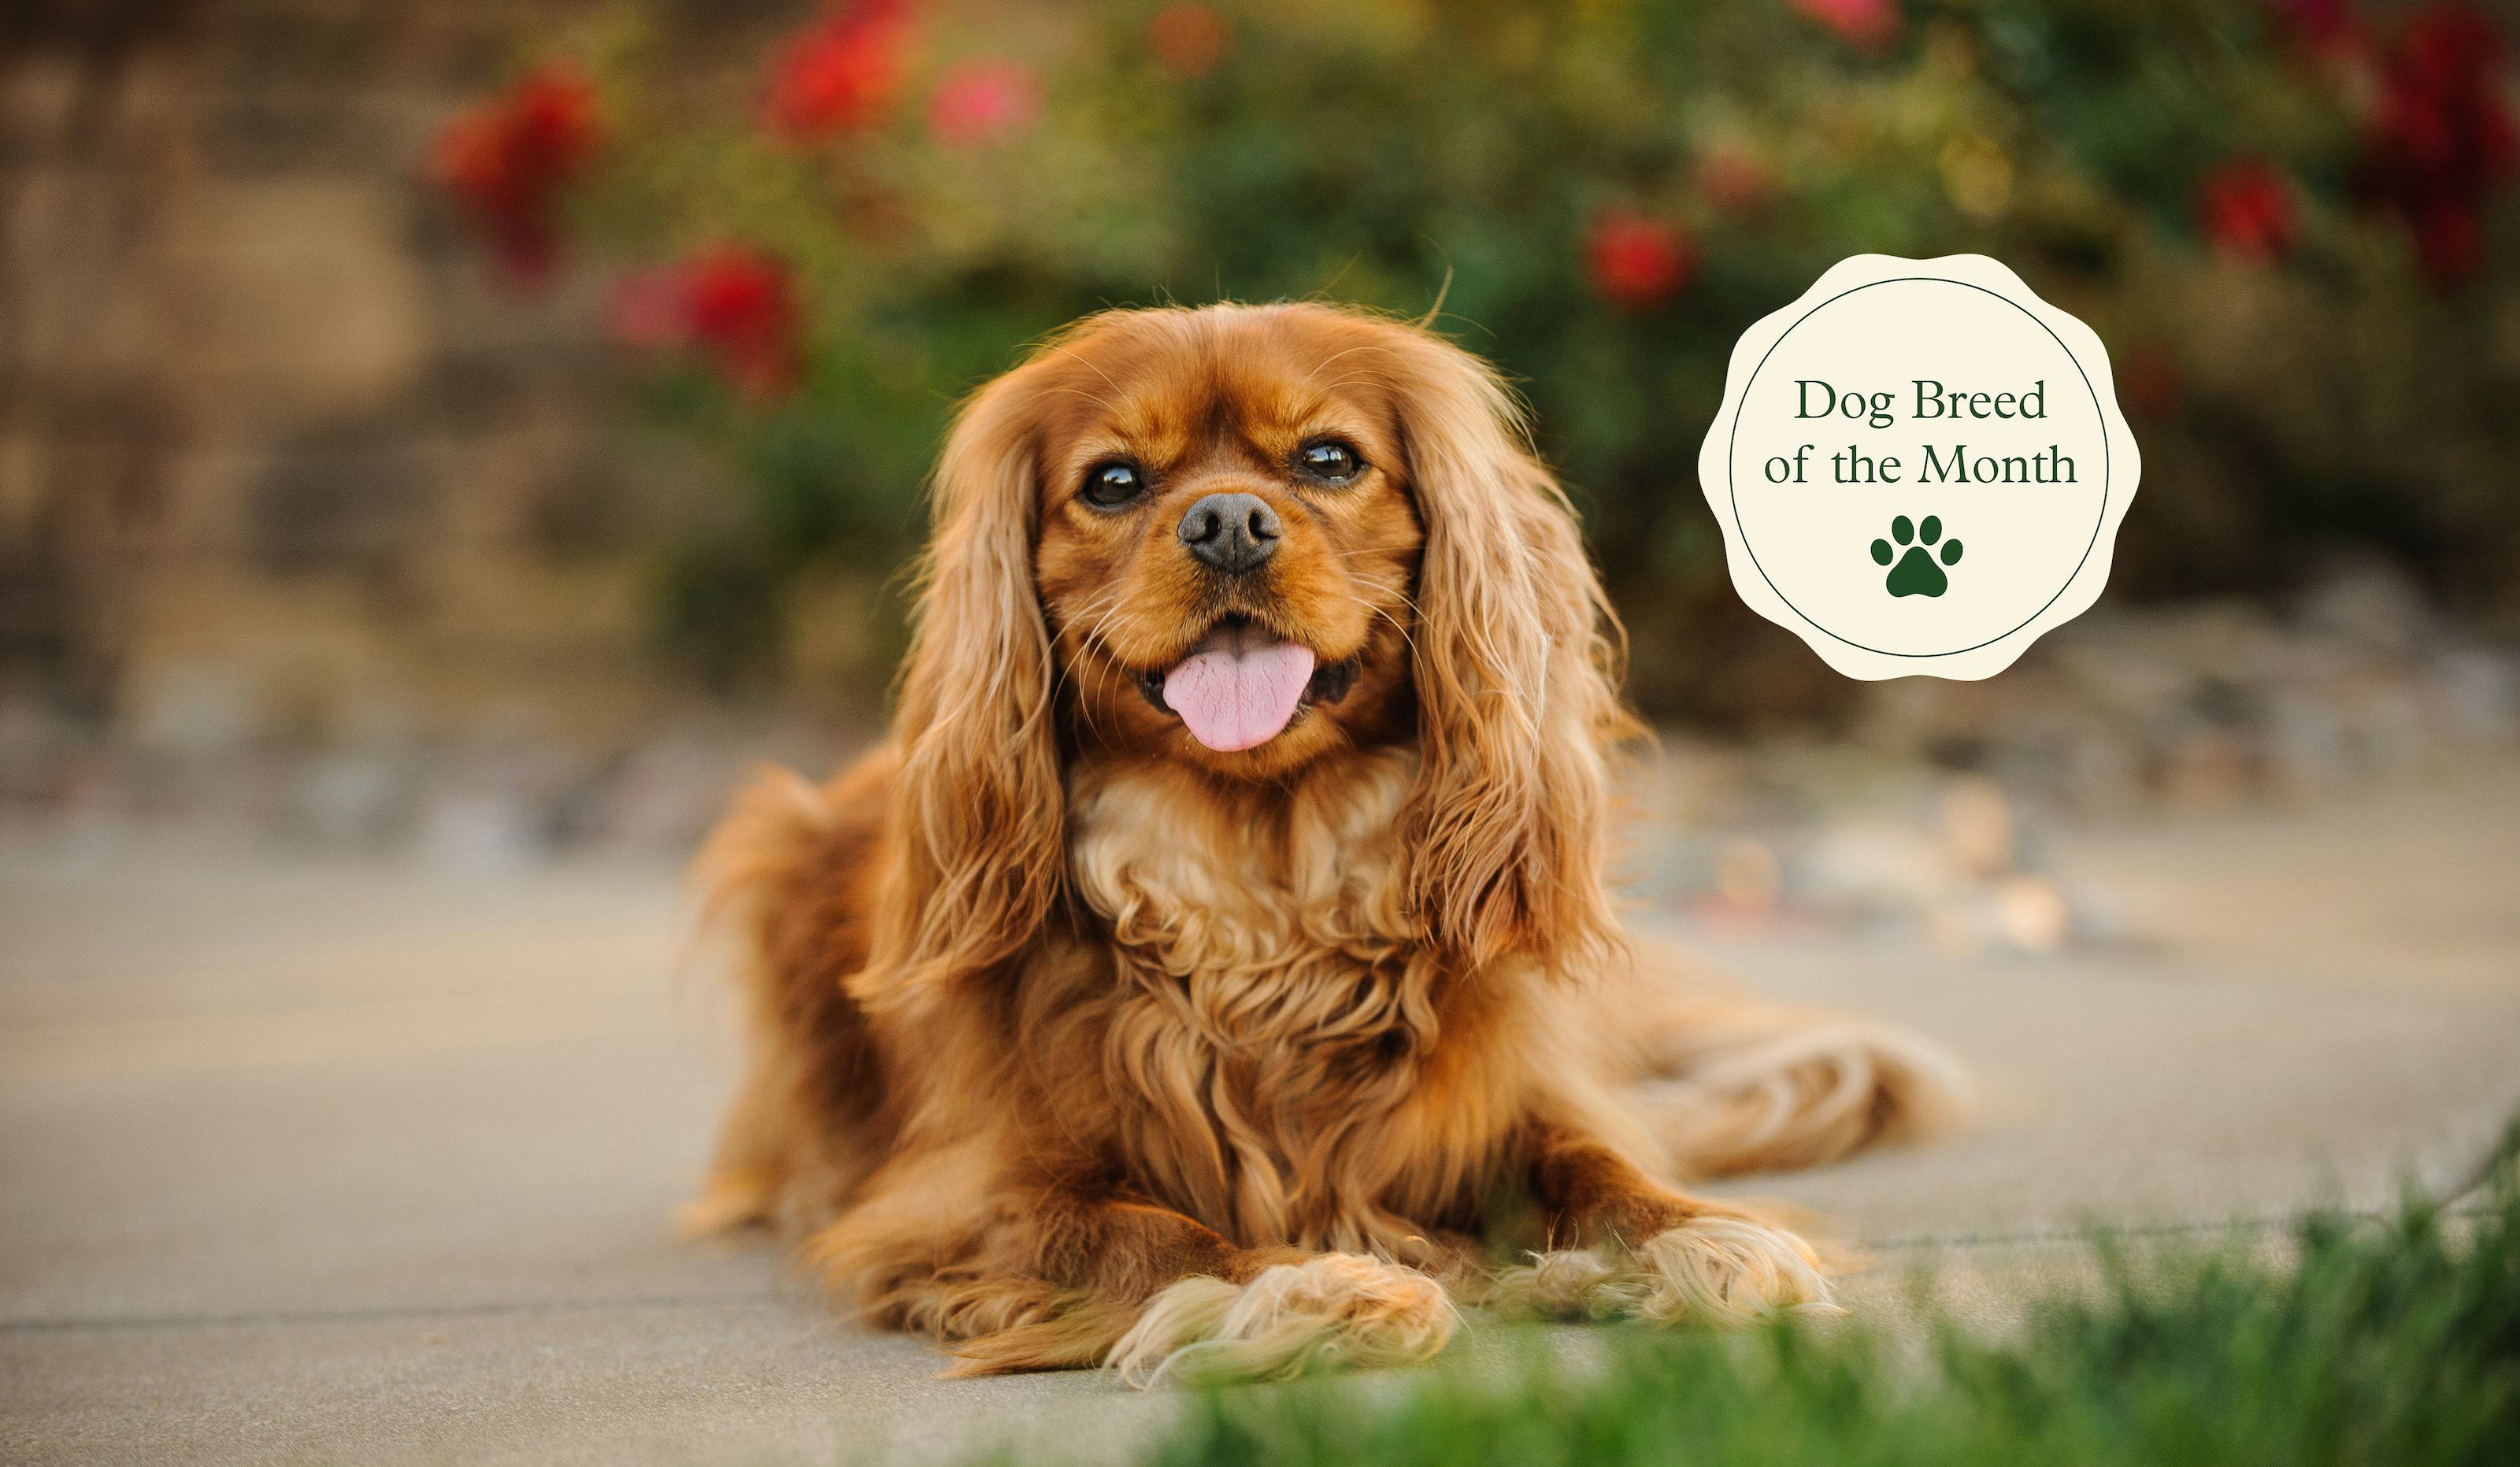

This is a dog photo and the breed is Cavalier_king_charles_spaniel


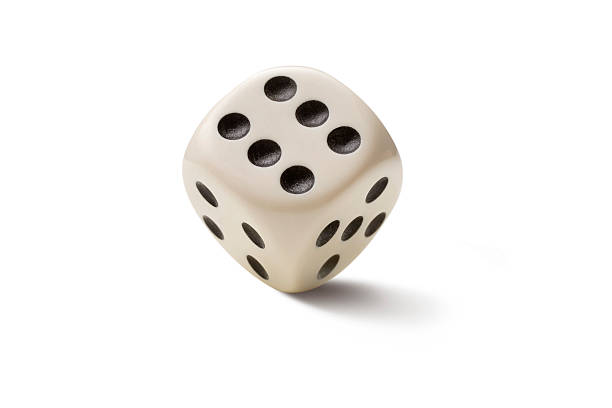

This is neither a dog nor a human


In [25]:
# Execute the algorithm from Step 6 on at least 6 images 

# human1 image
image_path = 'images/HumanFace2.jpg'
main_detector_func(image_path)

# human2 image
image_path = 'images/HumanFace3.jpg'
main_detector_func(image_path)

# dog1 image
image_path = 'images/Labrador_retriever_06449.jpg'
main_detector_func(image_path)

# dog2 image
image_path = 'images/Puppy.jpg'
main_detector_func(image_path)

# dog3 image
image_path = 'images/cavalier-king-charles-spaniel.jpg'
main_detector_func(image_path)

# etc image
image_path = 'images/random.jpg'
main_detector_func(image_path)


# Conclusion

In this article, I took you on a journey of how to apply convolutional neural network (CNN) in order to identify and classify images of dogs according to their breed. The way we tackled this project was dividing the problem to some small steps including: importing and processing the data, writing functions that can detect human and/or dog in a given image, explored different CNN models (both writing from scratch or using transfer learning) that can estimate the dog breed, and used the best model that generates the best accuracy on the test dataset for our algorithm. At the end, we combined all the functions developed at each step together into a main function and tested that on different images of human, dog, and random images.

Although there is no perfect algorithm for such task and there are many other ways to tackle this problem, our algorithm showed very good performance on different occasions. To improve this algorithm we can 1) expand our data by using Image Augmentation in order to make the model invariant to the factors such as scale, rotation, and translation 2) increase the number of epochs while using EarlyStopping that can help to get to a better accuracy while avoiding overfitting 3) fine-tune our model by unfreezing a few of the top layers (in the pretrained base model) and jointly train them along with the newly added layers (we can add more layers such as Covolutional, Maxpooling, etc and train them); with this we can fine-tune higher-order features in the base model in order to make them more relevant to our specific task.


# Reflection

Deep neural network and specially convolutional neural network have indeed introduced a new era in the field of machine learning and creating intelligent systems. These powerful networks has enabled us to excel at different fields from health to technology and industry. 

While I enjoyed working on this project I learned important points doing it. Keras package in python is very powerful and easy to use to make CNN models from scratch. However, you have to bear in mind that as you increase your layers in your CNN model it increases the computational complexity, which means that you need powerful computers with high GPUs. Also, as you need big datasets for training your model you have to be considerate. For such cases it is better not to use Jupyter notebook as it is not designed to handle huge quantities of data.  Here, we had to decrease the size of the training dataset, which is not recommended as it can lower the predictive power of your model, but it was not a big source of concern in this project as we later used transfer learning. 

Transfer learning is another very helpful technique that can help to save time and energy while designing CNN models. Everyday, many groups around the world are working on developing very powerful CNN models, which can be used as pre-trained models by many others in their own projects without them needing to start from scratch. In this project we saw the performance of utilizing five different pre-trained CNN models in our model and we chose the best one with the best accuracy value on the test dataset. However, there are different techniques that can be used to improve the performance of such CNN models. One way to do that as discussed above is by fine-tuning our model, which can be done by unfreezing a few of the top layers (in the pretrained base model) and jointly train them along with the newly added layers. With this we can fine-tune higher-order features in the base model in order to make them more relevant to our specific task.